In [1]:
!pip install git+git://github.com/linalgo/linalgo-sdk.git requests pillow

  Cloning git://github.com/linalgo/linalgo-sdk.git to /tmp/pip-req-build-56j9utuk
  Running command git clone -q git://github.com/linalgo/linalgo-sdk.git /tmp/pip-req-build-56j9utuk


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import requests, io
from PIL import Image

from linalgo.annotate.models import Document, Annotation, Entity
from linalgo.hub.client import LinalgoClient
from linalgo.annotate.bbox import draw_bounding_boxes

In [4]:
client = LinalgoClient(token=MYTOKEN, api_url='https://prod.linhub.api.linalgo.com/v1')
task = client.get_task('a9b4a03b-3af5-476f-8656-c69a32ea9866', verbose=True)

Retrivieving task with id a9b4a03b-3af5-476f-8656-c69a32ea9866...
Retrieving annotators... (9 found)
Retrieving entities... (8 found)
Retrieving documents... (348 found)
Retrieving annotations... (35049 found)


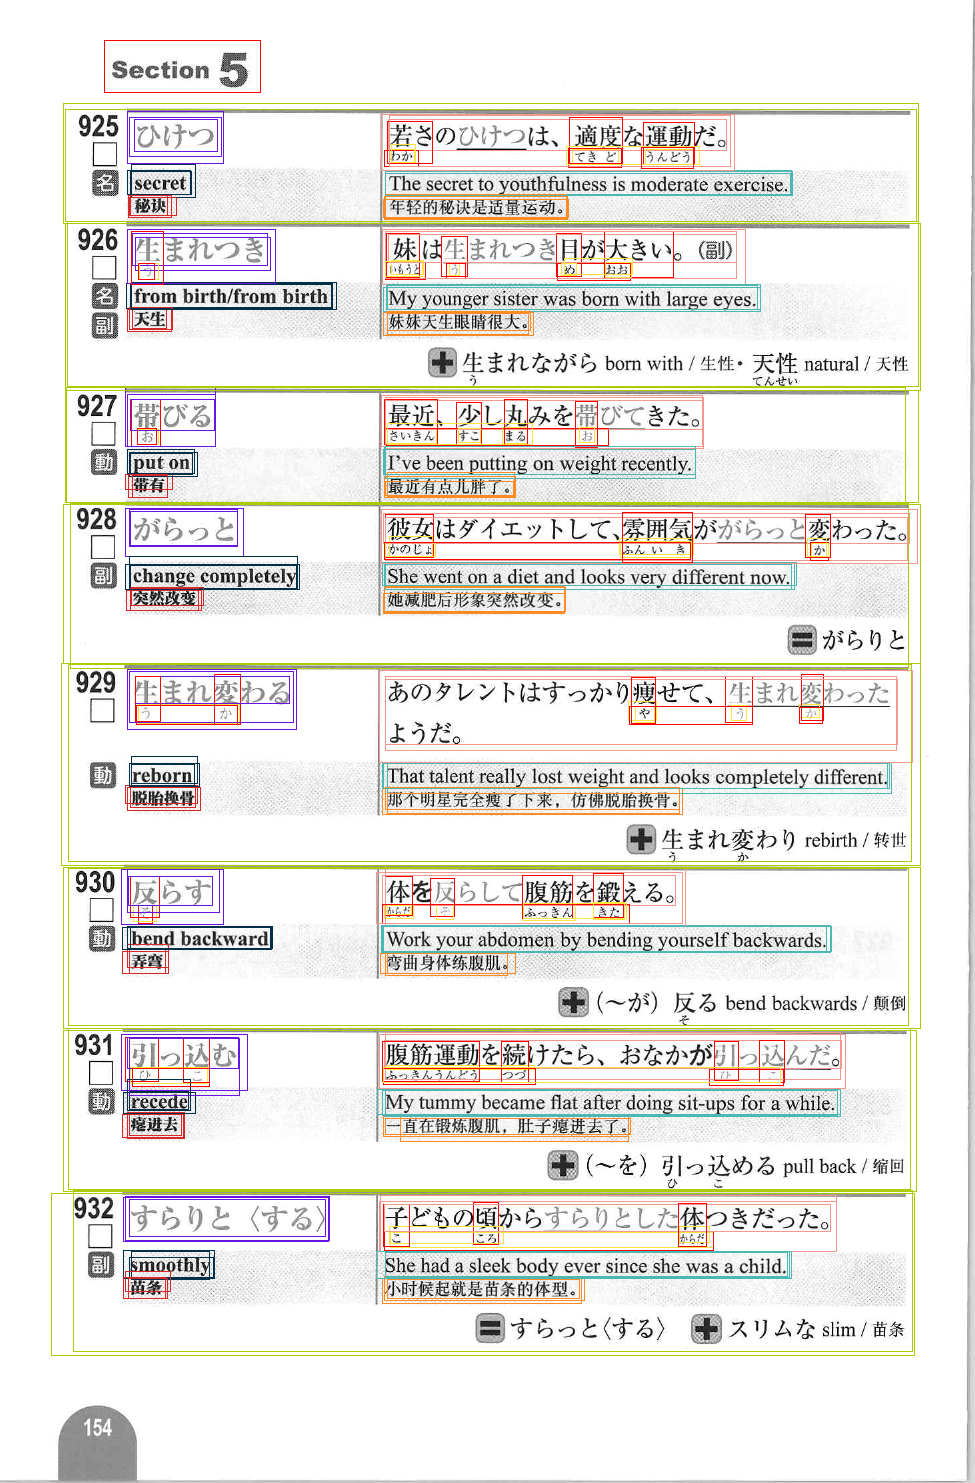

In [5]:
doc = task.documents[0]
response = requests.get(doc.content)
img = Image.open(io.BytesIO(response.content))
draw_bounding_boxes(img, doc.annotations)

In [6]:
doc.annotations 
doc.content

'https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-160.png'

In [7]:
doc.content

'https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-160.png'

In [8]:
len(task.documents)

348

In [9]:
task.documents[0].annotations[3].target.selectors

[{(70.1027981667144, 503.44106140422787), (908.9565846710537, 503.44106140422787), (908.9565846710537, 668.3550411039973), (70.1027981667144, 668.3550411039973)}]

New features: 
Compute distance of boxes with item box. 
Change features to give information relative to the box. 
Associate other bounding box to the item box. 
Compute new features. 
One less class. 

Compute distance of all boxes and identify which box is the closest. 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
ent_list =[]
coord_list = []
doc_list = []
for i in range(len(task.documents)): 
    document = task.documents[i]
    for ant in range(len(document.annotations)): 
        annotation = document.annotations[ant]
        entity = annotation.entity.name
        coordinates = annotation.target.selectors[0]
        ent_list.append(entity)
        coord_list.append(coordinates)
        doc_list.append(document.content)

In [12]:
top= []
bottom=[]
left=[]
right=[]
area = []
width=[]
height=[]

for i in range(len(coord_list)):
    top.append(coord_list[i].top)
    bottom.append(coord_list[i].bottom)
    left.append(coord_list[i].left)
    right.append(coord_list[i].right)
    area.append(coord_list[i].area)
    width.append(coord_list[i].width)
    height.append(coord_list[i].height)

In [13]:
pd.options.display.max_colwidth = 200
elem = {'Entity': ent_list, 'document_id': doc_list}
df= pd.DataFrame(elem)
df.columns = ['Entity', 'document_id']

df['document_no'] = df.groupby(['document_id']).ngroup()

df['top'] = pd.DataFrame(top)
df['bottom'] = pd.DataFrame(bottom)
df['left'] = pd.DataFrame(left)
df['right'] = pd.DataFrame(right)
df['area'] = pd.DataFrame(area)
df['width'] = pd.DataFrame(width)
df['height'] = pd.DataFrame(height)

df = df.sort_values(by=['document_no', 'top'])
df['entity_count'] = df.groupby(['document_id', 'Entity']).cumcount()
df = df.reset_index(drop=True)
df.head()

,Entity,document_id,document_no,top,bottom,left,right,area,width,height,entity_count
0,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-001.png,0,107.952941,696.470588,156.705882,921.082353,449849.041938,764.376471,588.517647,0
1,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-001.png,0,192.708340,563.925457,176.074573,908.366265,271839.210901,732.291691,371.217118,1
2,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-002.png,1,844.000000,1002.000000,215.600006,281.600006,10428.000000,66.000000,158.000000,0
3,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-003.png,2,1161.091048,1278.824056,231.000288,322.344863,10754.271659,91.344575,117.733008,0
4,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-004.png,3,1228.077070,1319.421645,170.103904,267.538118,8900.086890,97.434214,91.344575,0


In [14]:
len(df)
df = df.drop_duplicates() # Remove duplicates
len(df)

35049

In [15]:
df = df.dropna()
df.isnull().sum().sort_values(ascending=False)

Entity          0
document_id     0
document_no     0
top             0
bottom          0
left            0
right           0
area            0
width           0
height          0
entity_count    0
dtype: int64

In [16]:
keep_df = df[df['Entity'] == 'word-en']
keep_s = keep_df.document_no.reset_index(drop=True).tolist()
df = df[df['document_no'].isin(keep_s)]
len(df)

34546

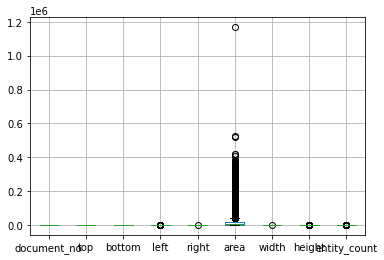

In [17]:
df.boxplot();

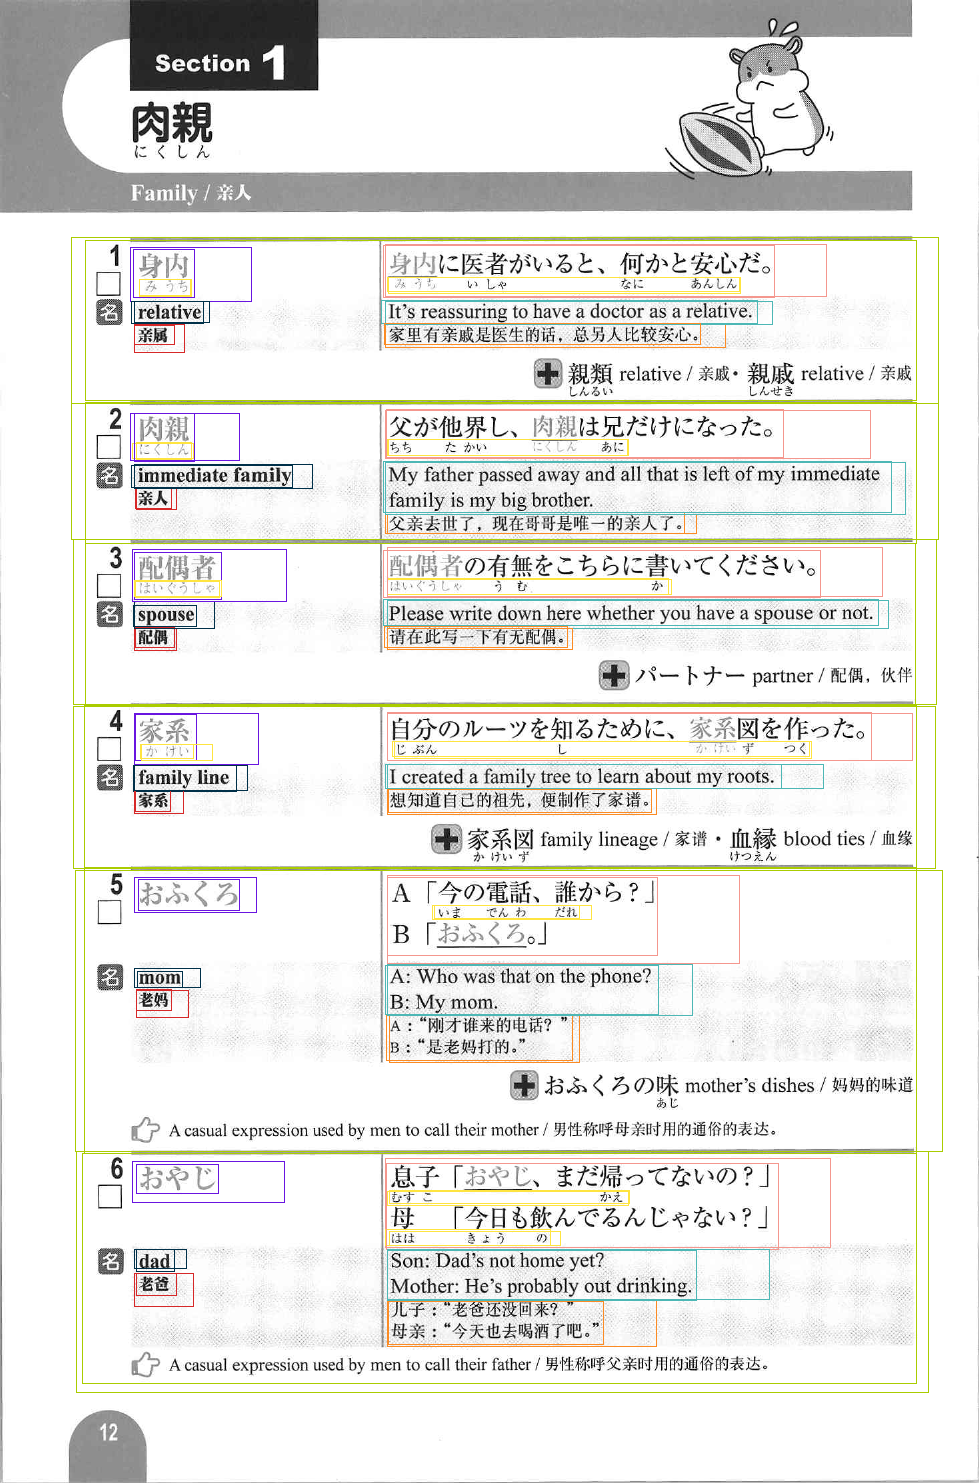

In [18]:
doc_261 = task.documents[261]
response_261 = requests.get(doc_261.content)
img_261 = Image.open(io.BytesIO(response_261.content))
draw_bounding_boxes(img_261, doc_261.annotations)

In [19]:
df

,Entity,document_id,document_no,top,bottom,left,right,area,width,height,entity_count
26,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,237.280000,403.027059,71.532941,938.651765,143722.394651,867.118824,165.747059,0
27,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,240.279670,400.976264,85.704850,916.735810,133543.845096,831.030960,160.696594,1
28,sent-jp,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,244.258824,296.600000,385.580000,826.990588,23103.949495,441.410588,52.341176,0
29,sent-jp,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,245.952646,297.105525,383.918380,774.934457,20001.598190,391.016077,51.152879,1
30,word-jp,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,247.748235,301.834118,130.852941,251.237647,6511.113039,120.384706,54.085882,0
...,...,...,...,...,...,...,...,...,...,...,...
34719,word-en,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-305.png,304,1199.537415,1248.937415,135.704082,329.837415,9590.186667,194.133333,49.400000,5
34720,word-zh,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-305.png,304,1249.763002,1294.843647,131.658163,343.432357,9546.917274,211.774194,45.080645,4
34721,word-zh,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-305.png,304,1250.534958,1308.765217,133.412006,351.177222,12680.524970,217.765216,58.230259,5
34722,sent-zh,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-305.png,304,1299.466255,1351.214844,384.781519,873.075894,25268.544814,488.294376,51.748589,4


In [20]:
item_df = df[df['Entity'] == 'item']
item_df.drop(labels=(['Entity','document_id']), axis = 1, inplace=True)
item_df.rename(columns = {'top':'top_item', 'bottom':'bottom_item', 'left':'left_item', 'right':'right_item', 'width':'width_item', 'area':'area_item', 'height':'height_item'}, inplace = True)

/home/zapjanice/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/zapjanice/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [21]:
merge_df = df.merge(item_df, how='left', on=(['document_no', 'entity_count']))
merge_df['y_diff'] = pd.Series.abs(merge_df['top_item'] - merge_df['top'])
merge_df['x_diff'] = pd.Series.abs(merge_df['left_item'] - merge_df['left'])
merge_df.head()

,Entity,document_id,document_no,top,bottom,left,right,area,width,height,entity_count,top_item,bottom_item,left_item,right_item,area_item,width_item,height_item,y_diff,x_diff
0,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,237.280000,403.027059,71.532941,938.651765,143722.394651,867.118824,165.747059,0,237.28000,403.027059,71.532941,938.651765,143722.394651,867.118824,165.747059,0.000000,0.000000
1,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,240.279670,400.976264,85.704850,916.735810,133543.845096,831.030960,160.696594,1,240.27967,400.976264,85.704850,916.735810,133543.845096,831.030960,160.696594,0.000000,0.000000
2,sent-jp,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,244.258824,296.600000,385.580000,826.990588,23103.949495,441.410588,52.341176,0,237.28000,403.027059,71.532941,938.651765,143722.394651,867.118824,165.747059,6.978824,314.047059
3,sent-jp,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,245.952646,297.105525,383.918380,774.934457,20001.598190,391.016077,51.152879,1,240.27967,400.976264,85.704850,916.735810,133543.845096,831.030960,160.696594,5.672976,298.213530
4,word-jp,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,247.748235,301.834118,130.852941,251.237647,6511.113039,120.384706,54.085882,0,237.28000,403.027059,71.532941,938.651765,143722.394651,867.118824,165.747059,10.468235,59.320000


In [22]:
featured_df = merge_df[['Entity', 'top', 'bottom', 'left', 'right', 'area', 'width', 'height', 'x_diff', 'y_diff']]
featured_df

,Entity,top,bottom,left,right,area,width,height,x_diff,y_diff
0,item,237.280000,403.027059,71.532941,938.651765,143722.394651,867.118824,165.747059,0.000000,0.000000
1,item,240.279670,400.976264,85.704850,916.735810,133543.845096,831.030960,160.696594,0.000000,0.000000
2,sent-jp,244.258824,296.600000,385.580000,826.990588,23103.949495,441.410588,52.341176,314.047059,6.978824
3,sent-jp,245.952646,297.105525,383.918380,774.934457,20001.598190,391.016077,51.152879,298.213530,5.672976
4,word-jp,247.748235,301.834118,130.852941,251.237647,6511.113039,120.384706,54.085882,59.320000,10.468235
...,...,...,...,...,...,...,...,...,...,...
34541,word-en,1199.537415,1248.937415,135.704082,329.837415,9590.186667,194.133333,49.400000,92.880552,179.419768
34542,word-zh,1249.763002,1294.843647,131.658163,343.432357,9546.917274,211.774194,45.080645,94.801754,233.171395
34543,word-zh,1250.534958,1308.765217,133.412006,351.177222,12680.524970,217.765216,58.230259,90.588476,230.417311
34544,sent-zh,1299.466255,1351.214844,384.781519,873.075894,25268.544814,488.294376,51.748589,347.925109,282.874648


In [23]:
featured_df.isnull().sum().sort_values(ascending=False)

x_diff    3851
y_diff    3851
Entity       0
top          0
bottom       0
left         0
right        0
area         0
width        0
height       0
dtype: int64

In [24]:
featured_df['x_diff'].fillna(0, inplace = True)
featured_df['y_diff'].fillna(0, inplace = True)

/home/zapjanice/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


# Scaling and Modelling

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

mmscaler = MinMaxScaler()
ssscaler = StandardScaler()

cols = ['top', 'bottom', 'left', 'right', 'area', 'width', 'height', 'x_diff', 'y_diff']

# df[cols] = mmscaler.fit_transform(df[cols])
featured_df[cols] = ssscaler.fit_transform(featured_df[cols])

featured_df.head()

<ipython-input-25-73eadb07782f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_df[cols] = ssscaler.fit_transform(featured_df[cols])
/home/zapjanice/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,Entity,top,bottom,left,right,area,width,height,x_diff,y_diff
0,item,-1.286211,-0.932985,-1.213555,1.299706,2.827187,2.219660,2.692862,-1.110478,-0.692885
1,item,-1.277517,-0.938929,-1.115380,1.225190,2.590611,2.075962,2.581260,-1.110478,-0.692885
2,sent-jp,-1.265984,-1.241442,0.961989,0.920048,0.023694,0.524531,0.186879,1.064687,-0.619759
3,sent-jp,-1.261075,-1.239977,0.950479,0.743052,-0.048413,0.323865,0.160620,0.955021,-0.633442
4,word-jp,-1.255870,-1.226272,-0.802619,-1.037563,-0.361968,-0.753762,0.225432,-0.699613,-0.583196


In [26]:
featured_df.Entity.value_counts()

furi       7527
sent-en    3882
sent-jp    3868
word-jp    3862
word-zh    3861
sent-zh    3852
item       3851
word-en    3843
Name: Entity, dtype: int64

In [27]:
baseline_model = 7566/len(featured_df.Entity)*100
baseline_model

21.901233138424132

<AxesSubplot:>

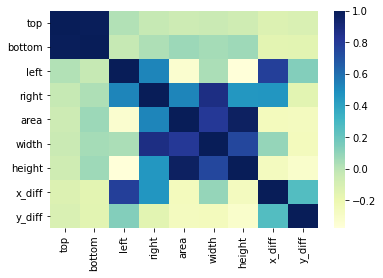

In [28]:
import seaborn as sns

# Heatmap
corr = featured_df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [29]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

,feature_1,feature_2,correlation
1,top,bottom,0.991398
9,bottom,top,0.991398
42,area,height,0.971663
58,height,area,0.971663
32,right,width,0.871441


In [30]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(featured_df, test_size=0.3)
# X_train = train_data.drop(['Entity'], axis = 1)
y_train = train_data.Entity
# X_test = test_data.drop(['Entity'], axis = 1)

X_train = train_data[['area', 'width', 'x_diff', 'y_diff']]
X_test = test_data[['area', 'width', 'x_diff', 'y_diff']]

y_test = test_data.Entity
X_train, len(X_train), len(X_test)

(           area     width    x_diff    y_diff
 6831   1.714055  2.221255 -1.110478 -0.692885
 1446   2.030421  2.166650 -1.110478 -0.692885
 29517  1.723766  2.197993 -1.110478 -0.692885
 20155  1.680763  2.208185 -1.110478 -0.692885
 27041 -0.339975 -0.028789  1.306975  0.862479
 ...         ...       ...       ...       ...
 17613 -0.386589  0.149380  1.184470  4.032372
 12801 -0.424782 -0.523247 -0.736319  0.208629
 11431 -0.308467 -0.500020 -0.676917 -0.592570
 28654  2.148698  2.243184 -1.110478 -0.692885
 9866  -0.425763 -0.393675  1.266733  3.344816
 
 [24182 rows x 4 columns],
 24182,
 10364)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=8)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.9677730605943651

In [32]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score
neigh_results = cross_validate(neigh, X_train, y_train, cv=5, scoring="accuracy")
neigh_results_f1 = cross_validate(neigh, X_train, y_train, cv=5, scoring="f1_weighted")

neigh_results['test_score'].mean(), neigh_results_f1['test_score'].mean()

(0.970804581721439, 0.9709199208551158)

In [33]:
from sklearn.model_selection import learning_curve

train_sizes = [750,1000, 2000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 19000]
train_sizes, train_scores, test_scores = learning_curve(
    estimator=neigh, X=X_train, y=y_train, train_sizes=train_sizes, cv=5, scoring="accuracy")

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

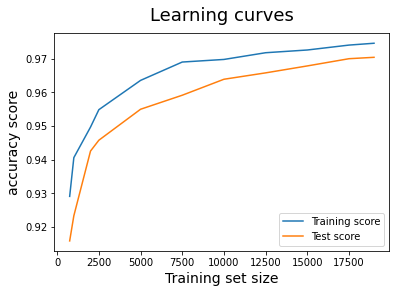

In [34]:
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('accuracy score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend();

Random forest at 10,000 train set size

Curves does not converge, so model is still learning. 

You can use data augmentation to increase the number of data points to better train model. 
Data augmentation (like mirror, crop, etc.)

In [35]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification

lin_svc = LinearSVC(random_state=0, max_iter=10500)
lin_svc.fit(X_train, y_train)
lin_svc.score(X_test, y_test)

0.7734465457352374

In [36]:
lin_svc_results = cross_validate(lin_svc, X_train, y_train, cv=5, scoring="accuracy")
lin_svc_results['test_score'].mean()

0.7734266107357932

In [37]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=8)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

rfc_results = cross_validate(rfc, X_train, y_train, cv=5, scoring="accuracy")
rfc_results['test_score'].mean()

0.9630304929964142

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8),
                               n_estimators=100)    
abc.fit(X_train, y_train)
abc.score(X_test, y_test)

abc_results = cross_validate(abc, X_train, y_train, cv=5, scoring="accuracy")
abc_results['test_score'].mean()

0.9836241369386414

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)
gbc.fit(X_train, y_train)
gbc.score(X_test, y_test)

gbc_results = cross_validate(abc, X_train, y_train, cv=5, scoring="accuracy")
gbc_results['test_score'].mean()

0.9829625185514267

In [40]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric= 'merror', early_stopping_rounds=5) 
xgb_results = cross_validate(xgb, X_train, y_train, cv=5, scoring="accuracy")
xgb_results['test_score'].mean()

[0]	validation_0-merror:0.03560
[1]	validation_0-merror:0.03387


/home/zapjanice/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-merror:0.03309
[3]	validation_0-merror:0.02856
[4]	validation_0-merror:0.02711
[5]	validation_0-merror:0.02692
[6]	validation_0-merror:0.02625
[7]	validation_0-merror:0.02595
[8]	validation_0-merror:0.02489
[9]	validation_0-merror:0.02489
[10]	validation_0-merror:0.02364
[11]	validation_0-merror:0.02296
[12]	validation_0-merror:0.02277
[13]	validation_0-merror:0.02210
[14]	validation_0-merror:0.02142
[15]	validation_0-merror:0.02046
[16]	validation_0-merror:0.02084
[17]	validation_0-merror:0.02007
[18]	validation_0-merror:0.01939
[19]	validation_0-merror:0.01911
[20]	validation_0-merror:0.01901
[21]	validation_0-merror:0.01853
[22]	validation_0-merror:0.01814
[23]	validation_0-merror:0.01795
[24]	validation_0-merror:0.01756
[25]	validation_0-merror:0.01737
[26]	validation_0-merror:0.01698
[27]	validation_0-merror:0.01698
[28]	validation_0-merror:0.01698
[29]	validation_0-merror:0.01660
[30]	validation_0-merror:0.01621
[31]	validation_0-merror:0.01611
[32]	validation_0-

/home/zapjanice/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:12:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:12:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:12:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

0.9862294677452699

In [41]:
1- 0.11326

0.88674